A notebook with examples for how to train and evaluate probes, along with plotting results.

# Do probe training (HF dataset activations)

Load the activations and labels from HF, aggregate, and construct datasets to train the probe on (note sklearn doesn't require a validation dataset).

In [2]:
import probe_gen.probes as probes
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

# Load the activations and labels from hf
activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__on_policy", "../data/refusal/on_policy_raw.jsonl", 20)
# Aggregate the activations
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
# Create train, val, and test datasets
train_dataset, val_dataset, test_dataset = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0, test_size=0.2, balance=True)

Create a probe and fit it.

In [3]:
# Initialise and fit a probe with the datasets
probe = probes.SklearnLogisticProbe(use_bias=False)
probe.fit(train_dataset, val_dataset, normalize=True)

Training probe...


Evaluate the probe on test dataset.

In [4]:
# Make predictions
y_pred = probe.predict(test_dataset['X'])
y_pred_proba = probe.predict_proba(test_dataset['X'])  # probabilities for class 1

# Evaluate the model
eval_dict, _, _ = probe.eval(test_dataset)
print(eval_dict)
print(classification_report(test_dataset['y'], y_pred))

{'accuracy': 0.875, 'roc_auc': 0.9477040816326531, 'tpr_at_1_fpr': np.float64(0.5)}
              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88        28
         1.0       0.89      0.86      0.87        28

    accuracy                           0.88        56
   macro avg       0.88      0.88      0.87        56
weighted avg       0.88      0.88      0.87        56



Nice visualisation to see how the probe splits the two classes

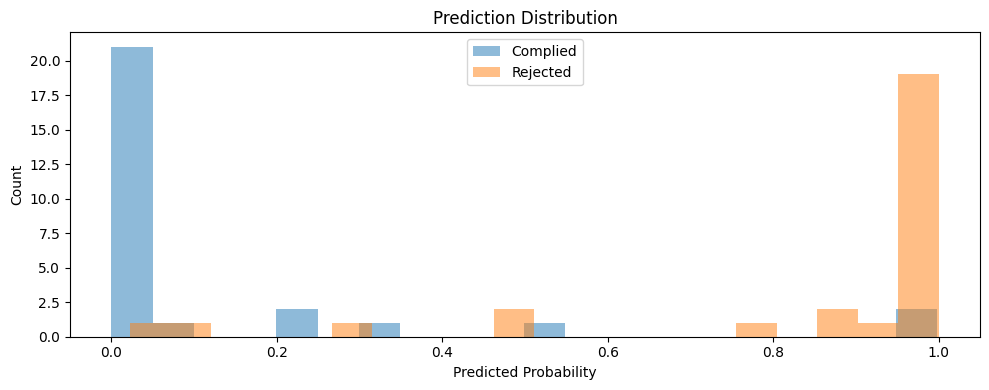

In [5]:
from probe_gen.standard_experiments.experiment_plotting import plot_per_class_prediction_distributions

plot_per_class_prediction_distributions(test_dataset['y'], y_pred_proba)

# Testing On-Off Probes

In [2]:
import probe_gen.probes as probes
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve

activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__on_policy", "../data/refusal/on_policy_raw.jsonl", 18)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
train_dataset_on, val_dataset_on, test_dataset_on = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0, test_size=0.2, balance=True)

activations_tensor, attention_mask, labels_tensor = probes.load_hf_activations_and_labels_at_layer("NLie2/anthropic-refusal-activations", "refusal_meta-llama_Llama-3.2-3B-Instruct__off_policy_other_model", "../data/refusal/off_policy_raw.jsonl", 18)
activations_tensor = probes.MeanAggregation()(activations_tensor, attention_mask)
train_dataset_off, val_dataset_off, test_dataset_off = probes.create_activation_datasets(activations_tensor, labels_tensor, val_size=0, test_size=0.2, balance=True)

In [3]:
# Initialise and fit a probe with the datasets
probe_on = probes.SklearnLogisticProbe(use_bias=False)
probe_on.fit(train_dataset_on, val_dataset_on, normalize=True)
# Initialise and fit a probe with the datasets
probe_off = probes.SklearnLogisticProbe(use_bias=False)
probe_off.fit(train_dataset_off, val_dataset_off, normalize=True)

Training probe...
Training probe...


In [4]:
eval_dict_on_on, _, y_pred_proba_on_on = probe_on.eval(test_dataset_on)
eval_dict_on_off, _, y_pred_proba_on_off = probe_on.eval(test_dataset_off)
eval_dict_off_on, _, y_pred_proba_off_on = probe_off.eval(test_dataset_on)
eval_dict_off_off, _, y_pred_proba_off_off = probe_off.eval(test_dataset_off)
print(eval_dict_on_on)
print(eval_dict_on_off)
print(eval_dict_off_on)
print(eval_dict_off_off)

{'accuracy': 0.9107142857142857, 'roc_auc': 0.9477040816326531, 'tpr_at_1_fpr': np.float64(0.4642857142857143)}
{'accuracy': 0.6057692307692307, 'roc_auc': 0.7444526627218935, 'tpr_at_1_fpr': np.float64(0.19230769230769232)}
{'accuracy': 0.7678571428571429, 'roc_auc': 0.8762755102040817, 'tpr_at_1_fpr': np.float64(0.39285714285714285)}
{'accuracy': 0.75, 'roc_auc': 0.8180473372781065, 'tpr_at_1_fpr': np.float64(0.40384615384615385)}


In [ ]:
from probe_gen.probes import save_probe_dict_results
save_probe_dict_results(eval_dict_on_on, "mean", False, True, "refusal_on", "refusal_on")
save_probe_dict_results(eval_dict_on_off, "mean", False, True, "refusal_on", "refusal_off")
save_probe_dict_results(eval_dict_off_on, "mean", False, True, "refusal_off", "refusal_on")
save_probe_dict_results(eval_dict_off_off, "mean", False, True, "refusal_off", "refusal_off")

wandb: ERROR Failed to detect the name of this notebook. You can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: samdower to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


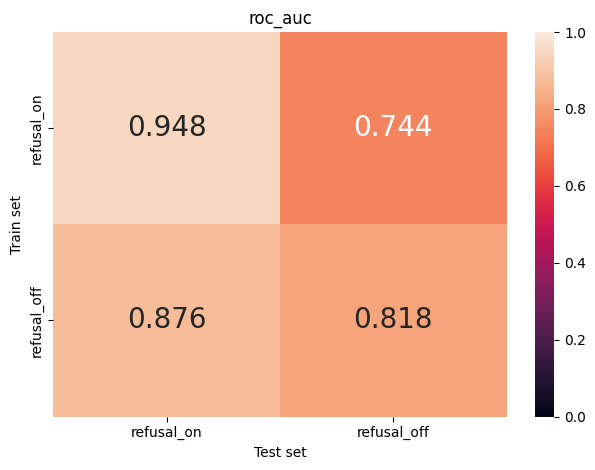

In [5]:
from probe_gen.standard_experiments.experiment_plotting import plot_results_table

plot_results_table(['refusal_on', 'refusal_off'], 'roc_auc')

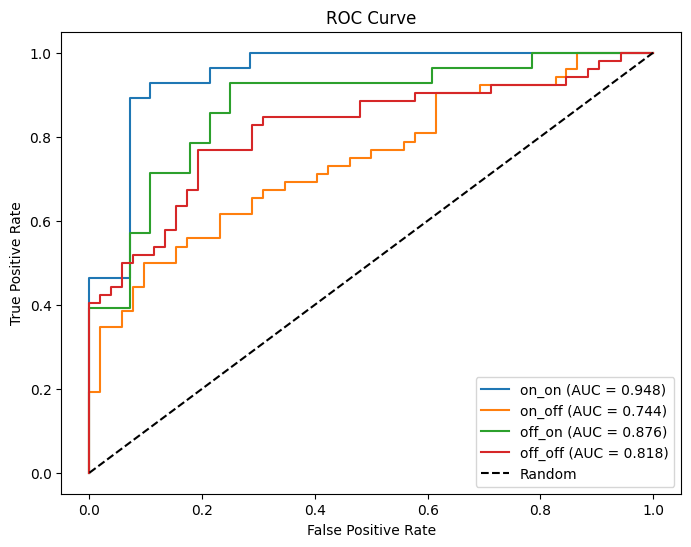

In [6]:
from probe_gen.standard_experiments.experiment_plotting import plot_roc_curves

plot_roc_curves(
    [test_dataset_on['y'], test_dataset_off['y'], test_dataset_on['y'], test_dataset_off['y']],
    [y_pred_proba_on_on, y_pred_proba_on_off, y_pred_proba_off_on, y_pred_proba_off_off],
    ['on_on', 'on_off', 'off_on', 'off_off']
)

# Layer experiments

loading activations for each layer (may take ~ 1 minute)
######################### Evaluating layer 18 #############################
Training probe...
######################### Evaluating layer 19 #############################
Training probe...
######################### Evaluating layer 20 #############################
Training probe...
######################### Evaluating layer 21 #############################
Training probe...
######################### Evaluating layer 22 #############################
Training probe...
######################### Evaluating layer 23 #############################
Training probe...
######################### Evaluating layer 24 #############################
Training probe...
######################### Evaluating layer 25 #############################
Training probe...
######################### Evaluating layer 26 #############################
Training probe...
######################### Evaluating layer 27 #############################
Training probe...


/workspace/LASR-probe-gen/src/probe_gen/standard_experiments/layer_experiments.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


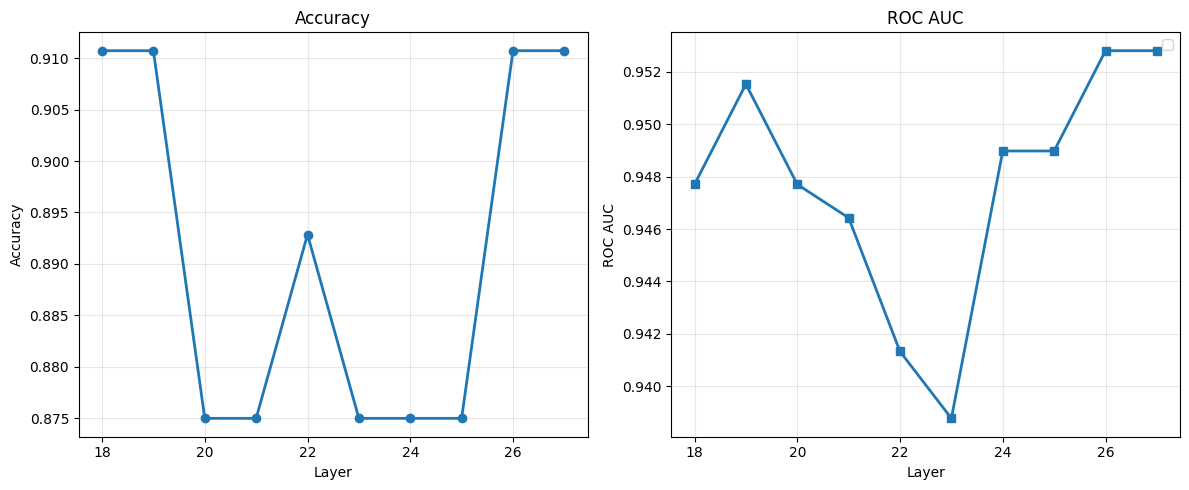

In [1]:
from probe_gen.standard_experiments.layer_experiments import run_layer_experiments
import probe_gen.probes as probes

probe = probes.SklearnLogisticProbe(use_bias=False)
run_layer_experiments(
    probe, 
    "NLie2/anthropic-refusal-activations", 
    "refusal_meta-llama_Llama-3.2-3B-Instruct__on_policy", 
    "../data/refusal/on_policy_raw.jsonl"
)

# Torch training (not yet integrated / needed)

In [ ]:
# Now actually train the probe on training data and evaluate on test data
import matplotlib.pyplot as plt
from probe_gen.probe_train import train_probe, evaluate_probe

print("Training linear probe...")
print(f"Train data: {train_activations.shape}, Val data: {val_activations.shape}")

# Train probe
model, train_losses, val_losses = train_probe(
    train_activations=train_activations,
    train_labels=train_labels,
    val_activations=val_activations,
    val_labels=val_labels,
    probe_type="mean",
    learning_rate=5e-3,
    batch_size=16,
    num_epochs=100,
    early_stop_patience=20,
    silent=True
)

# Evaluate probe
print("\nEvaluating probe...")
results = evaluate_probe(model, test_activations, test_labels)

print(f"Test Accuracy: {results['accuracy']:.4f}")
print(f"Test AUC-ROC: {results['auc_roc']:.4f}")
print(f"TPR at 1% FPR: {results['tpr_at_1_fpr']:.4f}")

# Plot training curves
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training Curves')

plt.subplot(1, 2, 2)
plt.hist(results['probabilities'][test_labels.numpy() == 0], alpha=0.5, label='Complied', bins=20)
plt.hist(results['probabilities'][test_labels.numpy() == 1], alpha=0.5, label='Rejected', bins=20)
plt.xlabel('Predicted Probability')
plt.ylabel('Count')
plt.legend()
plt.title('Prediction Distribution')

plt.tight_layout()
plt.show()

In [ ]:
import torch.nn as nn
# Show some values
criterion = nn.BCEWithLogitsLoss()
for i in range(10):
    logits = model(train_activations[i:i+1,:,:])
    print(train_labels[i], logits[0])
    print(torch.sigmoid(logits[0]))
    print(torch.sigmoid(logits[0]) > 0.5)
    print(criterion(logits[0], train_labels[i].float()))
    print()

### Do probe experiments (HF dataset activations)

In [ ]:
import json
import torch
import pandas as pd
from huggingface_hub import hf_hub_download
from probe_gen.probe_train import train_probe, evaluate_probe

for layer_num in range(5):
    print(f"\n\nLayer {layer_num}")
    # Load the labels
    labels_list = []
    with open("../data/refusal/on_policy_raw.jsonl", 'r') as file:
        for line in file:
            data = json.loads(line)
            if data["scale_labels"] <= 5:
                labels_list.append(1.0)
            else:
                labels_list.append(0.0)
    labels_tensor = torch.tensor(labels_list)
    print("loaded labels")

    # Load activations
    file_path = hf_hub_download(
        repo_id="NLie2/anthropic-refusal-activations",
        filename="dataframe_with_activations.pkl",
        repo_type="dataset")
    df = pd.read_pickle(file_path)
    print(f"loaded activations, with shape: {df.shape}")

    # Extract all activations
    all_activations = []
    for i in range(len(df)):
        all_activations.append(df.loc[i]["activations"][0])
    activations_tensor = torch.cat(all_activations, dim=0).unsqueeze(1).to(torch.float32)

    # Get indices for each label
    label_0_indices = (labels_tensor == 0.0).nonzero(as_tuple=True)[0]
    label_1_indices = (labels_tensor == 1.0).nonzero(as_tuple=True)[0]
    min_class_count = min(len(label_0_indices), len(label_1_indices))

    # Subsample both classes to same size
    label_0_indices = label_0_indices[:min_class_count]
    label_1_indices = label_1_indices[:min_class_count]

    # Shuffle indices
    label_0_indices = label_0_indices[torch.randperm(len(label_0_indices))]
    label_1_indices = label_1_indices[torch.randperm(len(label_1_indices))]

    # Compute split sizes
    n_total = min_class_count
    n_train = int(0.8 * n_total)
    n_val = int(0.1 * n_total)
    n_test = n_total - n_train - n_val

    # Split label 0s
    train_0 = label_0_indices[:n_train]
    val_0 = label_0_indices[n_train:n_train + n_val]
    test_0 = label_0_indices[n_train + n_val:]

    # Split label 1s
    train_1 = label_1_indices[:n_train]
    val_1 = label_1_indices[n_train:n_train + n_val]
    test_1 = label_1_indices[n_train + n_val:]

    # Concatenate splits and shuffle within each
    def get_split(indices_0, indices_1):
        indices = torch.cat([indices_0, indices_1])
        indices = indices[torch.randperm(len(indices))]
        return activations_tensor[indices], labels_tensor[indices]

    train_activations, train_labels = get_split(train_0, train_1)
    val_activations, val_labels = get_split(val_0, val_1)
    test_activations, test_labels = get_split(test_0, test_1)

    # Confirm balance
    print(f"Train: {train_labels.shape[0]} samples, {train_labels.sum()} positives")
    print(f"Val:   {val_labels.shape[0]} samples, {val_labels.sum()} positives")
    print(f"Test:  {test_labels.shape[0]} samples, {test_labels.sum()} positives")

    # Now actually train the probe on training data and evaluate on test data

    print("Training linear probe...")
    print(f"Train data: {train_activations.shape}, Val data: {val_activations.shape}")

    # Train probe
    model, train_losses, val_losses = train_probe(
        train_activations=train_activations,
        train_labels=train_labels,
        val_activations=val_activations,
        val_labels=val_labels,
        probe_type="mean",
        learning_rate=5e-3,
        batch_size=16,
        num_epochs=100,
        early_stop_patience=20,
        silent=True
    )

    # Evaluate probe
    print("\nEvaluating probe...")
    results = evaluate_probe(model, test_activations, test_labels)

    print("Test Accuracy, Test AUC-ROC, TPR at 1% FPR")
    print(f"{results['accuracy']:.4f}\t{results['auc_roc']:.4f}\t{results['tpr_at_1_fpr']:.4f}")
